In [ ]:
!pip3 install torch torchvision torchaudio

# Data Loading and Preprocessing


Loading from kaggle

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download pariza/bbc-news-summary

  0% 0.00/8.91M [00:00<?, ?B/s]
100% 8.91M/8.91M [00:00<00:00, 101MB/s]


In [ ]:
! unzip bbc-news-summary.zip

In [ ]:
# Imports
import matplotlib.pyplot as plt
import seaborn as sns
import glob as glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import GloVe
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
import spacy
import pandas as pd
import numpy as np
import os
import re
from nltk.corpus import stopwords
import random
from tqdm import tqdm
from transformers import BertTokenizer, BertModel, BertConfig
import math
import string
import nltk
from nltk.tokenize import sent_tokenize
import networkx as nx
from bs4 import BeautifulSoup

In [ ]:
os.listdir("BBC News Summary/News Articles")

['politics', 'business', 'entertainment', 'sport', 'tech']

In [ ]:
os.listdir("BBC News Summary/Summaries")

['politics', 'business', 'entertainment', 'sport', 'tech']

In [ ]:
articles_path = "BBC News Summary/News Articles"
summaries_path = "BBC News Summary/Summaries"
categories_list = os.listdir(articles_path)

In [ ]:
categories_list

['politics', 'business', 'entertainment', 'sport', 'tech']

In [ ]:
# Add data from files into dataframe for easier access
def create_dataframe(source_text_path,target_text_path):
    txt_files_source = [file for file in os.listdir(source_text_path) if file.endswith('.txt')]
    txt_files_target = [file for file in os.listdir(target_text_path) if file.endswith('.txt')]
    df = pd.DataFrame(columns=['headlines','text'])
    for source,target in zip(txt_files_source,txt_files_target):
        assert source==target
        source_file_path = os.path.join(source_text_path, source)
        target_file_path = os.path.join(target_text_path, target)
        # Read the content of the file
        with open(source_file_path,'r',encoding='latin-1') as file:
            source_text = file.read()
        with open(target_file_path,'r',encoding='latin-1') as file:
            target_text = file.read()
        df.loc[len(df.index)] = [source_text,target_text]
    return df

In [ ]:

def read_file(articles_path, summaries_path, categories_list, encoding = "ISO-8859-1"):
    articles = []
    summaries = []
    categories = []
    for category in categories_list:
        article_paths = glob.glob(os.path.join(articles_path, category, '*.txt'), recursive = True)
        summary_paths = glob.glob(os.path.join(summaries_path, category, '*.txt'), recursive = True)

        print(f'found {len(article_paths)} file in articles/{category} folder, {len(summary_paths)} file in summaries/{category}')

        if len(article_paths) != len(summary_paths):
            print("number of files is not equal")
            return
        for file in range(len(article_paths)):
            categories.append(category)
            with open(article_paths[file], mode = 'r', encoding = encoding ) as files:
                articles.append(files.read())

            with open(summary_paths[file], mode = 'r', encoding = encoding) as files:
                summaries.append(files.read())
    print(f'total {len(articles)} file in articles folder and {len(summaries)} files in summaries folder')
    return articles, summaries, categories

In [ ]:
articles, summaries, categories = read_file(articles_path, summaries_path, categories_list)

found 417 file in articles/politics folder, 417 file in summaries/politics
found 510 file in articles/business folder, 510 file in summaries/business
found 386 file in articles/entertainment folder, 386 file in summaries/entertainment
found 511 file in articles/sport folder, 511 file in summaries/sport
found 401 file in articles/tech folder, 401 file in summaries/tech
total 2225 file in articles folder and 2225 files in summaries folder


In [ ]:
data = pd.DataFrame({'articles': articles, 'summaries': summaries,
                    'categories': categories})

data.head()

,articles,summaries,categories
0,Guantanamo man 'suing government'\n\nA British...,He said he was sent there after being interrog...,politics
1,MPs issued with Blackberry threat\n\nMPs will ...,MPs will be thrown out of the Commons if they ...,politics
2,NHS waiting time target is cut\n\nHospital wai...,"""But let us not forget two thirds of those wai...",politics
3,UK heading wrong way - Howard\n\nTony Blair ha...,Tony Blair has had the chance to tackle the pr...,politics
4,Budget to set scene for election\n\nGordon Bro...,- Increase in the stamp duty threshold from Â£...,politics


In [ ]:
data.isnull().sum()

articles      0
summaries     0
categories    0
dtype: int64

In [ ]:

def check_accuracy(output,labels):
    _ , predpos = output.max(1)
    num_samples=len(labels)
    num_correct=(predpos==labels).sum()
    return (num_correct/num_samples)*100

def save_checkpoint(state,filename='weights.pth.tar'):
    print('Saving weights-->')
    torch.save(state,filename)

def load_checkpoint(checkpoint,model,optim):
    print('Loading weights-->')
    model.load_state_dict(checkpoint['state_dict'])
    optim.load_state_dict(checkpoint['optimizer'])

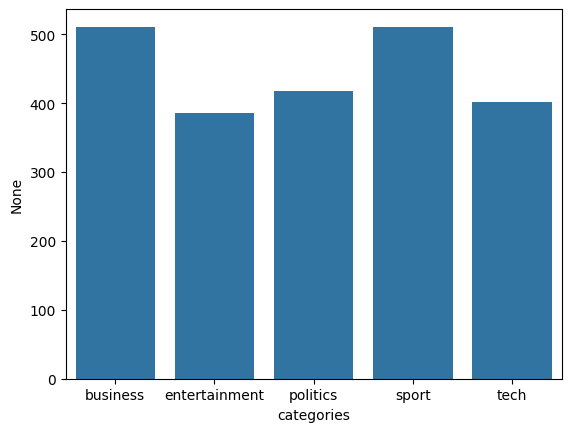

In [ ]:
category_sizes = data.groupby('categories').size()
sns.barplot(x = category_sizes.index, y = category_sizes)
plt.show()

In [ ]:
data['articles_length'] = data['articles'].apply(lambda x : len(x.split()))
data['summaries_length'] = data['summaries'].apply(lambda x : len(x.split()))

In [ ]:
data

,articles,summaries,categories,articles_length,summaries_length
0,Guantanamo man 'suing government'\n\nA British...,He said he was sent there after being interrog...,politics,615,269
1,MPs issued with Blackberry threat\n\nMPs will ...,MPs will be thrown out of the Commons if they ...,politics,162,70
2,NHS waiting time target is cut\n\nHospital wai...,"""But let us not forget two thirds of those wai...",politics,540,236
3,UK heading wrong way - Howard\n\nTony Blair ha...,Tony Blair has had the chance to tackle the pr...,politics,483,189
4,Budget to set scene for election\n\nGordon Bro...,- Increase in the stamp duty threshold from Â£...,politics,538,192
...,...,...,...,...,...
2220,Microsoft debuts security tools\n\nMicrosoft i...,Microsoft is releasing tools that clean up PCs...,tech,392,153
2221,Anti-spam screensaver scrapped\n\nA contentiou...,"""The idea was simply to slow spammers' sites a...",tech,375,147
2222,Nintendo handheld given Euro date\n\nNintendo'...,More than 120 games are in development for the...,tech,506,225
2223,PlayStation 3 chip to be unveiled\n\nDetails o...,"Sony, IBM and Toshiba, who have been working o...",tech,377,150


In [ ]:
category_length = data.groupby('categories').agg({'articles_length':'mean', 'summaries_length':'mean'})
category_length

,articles_length,summaries_length
categories,,
business,328.880392,139.929412
entertainment,330.621762,144.049223
politics,453.973621,195.709832
sport,329.262231,143.187867
tech,502.695761,213.837905


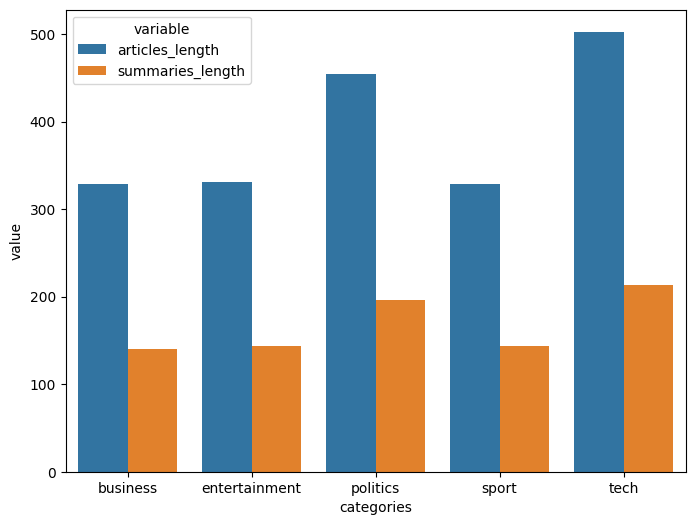

In [ ]:
#Length of article and summary for each category
data_new = pd.melt(category_length, ignore_index= False)
plt.figure(figsize=(8,6))
sns.barplot(x = data_new.index, y = 'value', hue = 'variable', data = data_new)
plt.show()

In [ ]:
df=data

In [ ]:
import plotly.express as px
import pandas as pd
from collections import Counter
import plotly.express as px
ct = Counter(data["categories"])
category_counts = pd.DataFrame({"category": ct.keys(), "value": ct.values()})

fig = px.scatter(category_counts, x='category', y='value', size='value',
                 title='Bubble Plot of Category Distribution',
                 size_max=40,
                 color='category')

fig.show()


In [ ]:
data

,articles,summaries,categories,articles_length,summaries_length
0,Guantanamo man 'suing government'\n\nA British...,He said he was sent there after being interrog...,politics,615,269
1,MPs issued with Blackberry threat\n\nMPs will ...,MPs will be thrown out of the Commons if they ...,politics,162,70
2,NHS waiting time target is cut\n\nHospital wai...,"""But let us not forget two thirds of those wai...",politics,540,236
3,UK heading wrong way - Howard\n\nTony Blair ha...,Tony Blair has had the chance to tackle the pr...,politics,483,189
4,Budget to set scene for election\n\nGordon Bro...,- Increase in the stamp duty threshold from Â£...,politics,538,192
...,...,...,...,...,...
2220,Microsoft debuts security tools\n\nMicrosoft i...,Microsoft is releasing tools that clean up PCs...,tech,392,153
2221,Anti-spam screensaver scrapped\n\nA contentiou...,"""The idea was simply to slow spammers' sites a...",tech,375,147
2222,Nintendo handheld given Euro date\n\nNintendo'...,More than 120 games are in development for the...,tech,506,225
2223,PlayStation 3 chip to be unveiled\n\nDetails o...,"Sony, IBM and Toshiba, who have been working o...",tech,377,150


In [ ]:
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
import numpy as np
import networkx as nx
import re
from bs4 import BeautifulSoup

In [ ]:
data['articles'] = data['articles'].str.strip()

In [ ]:
data['articles']= data['articles'].apply(lambda x : re.sub(r'[\n\r]*', '',str(x)))

In [ ]:
data['articles'][0]

'Guantanamo man \'suing government\'A British terror suspect held in Guantanamo Bay for 33 months plans to sue the government, it is reported.Martin Mubanga claimed in the Observer that an MI6 officer played a key role in consigning him to the US camp in Cuba, following his arrest in Zambia. Mr Mubanga, 32, from Wembley, London, said he was brutally interrogated and daubed with urine at the camp. The home secretary said he would not be launching an investigation and that the media reports were not "well informed". Mr Mubanga, who has dual British and Zambian nationality, was one of four Britons who were released from the US camp in January.He said he was sent there after being interrogated by a British man who said he was from MI6, shortly after his arrest in Zambia in March 2002. Mr Mubanga said he had been in Afghanistan and Pakistan to study Islam. But he said he was unable to return to the UK because he had lost his British passport, and was travelling on his Zambian passport inste

In [ ]:
data['articles']= data['articles'].apply(lambda x : x.lower())

In [ ]:
print("Library's punctuation: ", string.punctuation)
punctuation_list = list(string.punctuation)
print('Custom list:',punctuation_list,'\n')

Library's punctuation:  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
Custom list: ['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~'] 



In [ ]:
def remove_punctuation(text):
    punctuationfree = "".join([i for i in text if i not in punctuation_list])
    return punctuationfree


In [ ]:
data['articles']= data['articles'].apply(lambda x : remove_punctuation(x))

In [ ]:
import nltk
nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def read_article(text):
    sentences =[]
    sentences = sent_tokenize(text)
    for sentence in sentences:
        sentence.replace("[^a-zA-Z0-9]"," ")
    return sentences

In [ ]:
data['articles']= data['articles'].apply(read_article)

In [ ]:
def remove_links(text):
    if isinstance(text, str):
        remove_https = re.sub(r'http\S+', ' ', text)
        remove_com = re.sub(r"www\.[A-Za-z]*\.com", " ", remove_https)
        return remove_com
    else:
        return text

def strip_html_tags(text):
    if isinstance(text, str):
        soup = BeautifulSoup(text, "html.parser")
        stripped_text = soup.get_text(separator=" ")
        return stripped_text
    else:
        return text
data['articles'] = data['articles'].apply(remove_links)
data['articles'] = data['articles'].apply(strip_html_tags)


In [ ]:
data

,articles,summaries,categories,articles_length,summaries_length
0,[guantanamo man suing governmenta british terr...,He said he was sent there after being interrog...,politics,615,269
1,[mps issued with blackberry threatmps will be ...,MPs will be thrown out of the Commons if they ...,politics,162,70
2,[nhs waiting time target is cuthospital waitin...,"""But let us not forget two thirds of those wai...",politics,540,236
3,[uk heading wrong way howardtony blair has ha...,Tony Blair has had the chance to tackle the pr...,politics,483,189
4,[budget to set scene for electiongordon brown ...,- Increase in the stamp duty threshold from Â£...,politics,538,192
...,...,...,...,...,...
2220,[microsoft debuts security toolsmicrosoft is r...,Microsoft is releasing tools that clean up PCs...,tech,392,153
2221,[antispam screensaver scrappeda contentious ca...,"""The idea was simply to slow spammers' sites a...",tech,375,147
2222,[nintendo handheld given euro datenintendos ne...,More than 120 games are in development for the...,tech,506,225
2223,[playstation 3 chip to be unveileddetails of t...,"Sony, IBM and Toshiba, who have been working o...",tech,377,150


In [ ]:
from textblob import TextBlob

In [ ]:
def correct_me(sentence):
    textBlb = TextBlob(sentence)
    textCorrected = textBlb.correct()
    return str(textCorrected)

data['corrected_sentences'] = data['articles'].apply(lambda x: [correct_me(sentence) for sentence in x])


In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(sentences):
    text = ' '.join(sentences)
    text_no_stopwords = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text_no_stopwords
data['articles'] = data['articles'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
dataframe = data
dataframe

,articles,summaries,categories,articles_length,summaries_length
0,guantanamo man suing governmenta british terro...,He said he was sent there after being interrog...,politics,615,269
1,mps issued blackberry threatmps thrown commons...,MPs will be thrown out of the Commons if they ...,politics,162,70
2,nhs waiting time target cuthospital waiting ti...,"""But let us not forget two thirds of those wai...",politics,540,236
3,uk heading wrong way howardtony blair chance t...,Tony Blair has had the chance to tackle the pr...,politics,483,189
4,budget set scene electiongordon brown seek put...,- Increase in the stamp duty threshold from Â£...,politics,538,192
...,...,...,...,...,...
2220,microsoft debuts security toolsmicrosoft relea...,Microsoft is releasing tools that clean up PCs...,tech,392,153
2221,antispam screensaver scrappeda contentious cam...,"""The idea was simply to slow spammers' sites a...",tech,375,147
2222,nintendo handheld given euro datenintendos new...,More than 120 games are in development for the...,tech,506,225
2223,playstation 3 chip unveileddetails chip design...,"Sony, IBM and Toshiba, who have been working o...",tech,377,150


In [ ]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=False)

data['articles'] = data['articles'].values.tolist()
data_words = list(sent_to_words(data))
bigram = Phrases(data_words, min_count=5, threshold=10)
trigram = Phrases(bigram[data_words], threshold=10)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

data_bigram = [bigram_mod[doc] for doc in data_words]
data_trigram = [trigram_mod[bigram_mod[doc]] for doc in data_words]



In [ ]:
def tokenization(text):
    tokens = re.split('\W+',str(text))
    return tokens

In [ ]:
data['articles'] = data['articles'].apply(tokenization)


In [ ]:
data

,articles,summaries,categories,articles_length,summaries_length
0,"[tory, leader, cleared, workscottish, conserva...","Mr McLetchie said: ""I'm quite clear that no co...",politics,284,148
1,"[nat, insurance, rise, say, toriesnational, in...",Tony Blair has said he does not want higher ta...,politics,431,187
2,"[concessions, terrorcharles, clarke, says, des...","On Monday, MPs voted 272-219 in favour of the ...",politics,531,223
3,"[howard, pitches, uk, ethnic, votemichael, how...","""So I say to all those people from ethnic mino...",politics,377,158
4,"[labour, faces, cold, calls, inquirylabour, in...",The information commissioner is to look into a...,politics,695,313
...,...,...,...,...,...
2220,"[germany, nears, 1990, jobless, levelgerman, u...","""The three years of stagnation in the German e...",business,345,128
2221,"[yukos, drops, banks, court, bidrussian, oil, ...",Russian oil company Yukos has dropped the thre...,business,246,103
2222,"[fannie, mae, restate, booksus, mortgage, comp...",US mortgage company Fannie Mae should restate ...,business,249,72
2223,"[israel, looks, us, bank, chiefisrael, asked, ...",Mr Fischer will face a delicate balancing act ...,business,255,131


In [ ]:
data3=data

In [ ]:
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatizer(text):
  lemm_text = [wordnet_lemmatizer.lemmatize(word) for word in text]
  return lemm_text

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
data['articles'] = data['articles'].apply(lemmatizer)

In [ ]:
from wordcloud import WordCloud

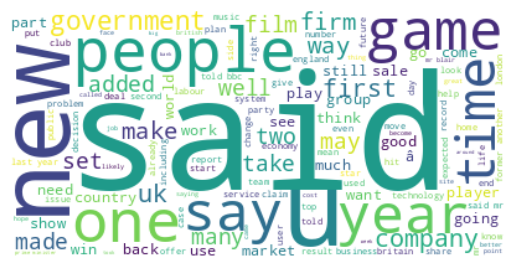

In [ ]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

flat_list = [item for sublist in data['articles'] for item in sublist]
unique_string = " ".join(flat_list)


wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
wordcloud.generate(unique_string)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

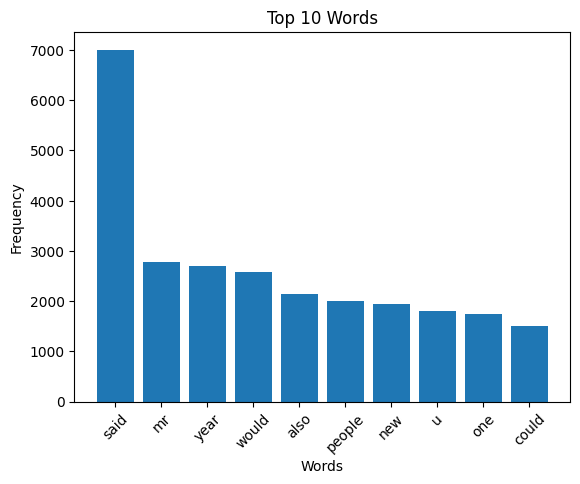

In [ ]:
word_counts = Counter(unique_string.split())

top_words = word_counts.most_common(10)


plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Words')
plt.xticks(rotation=45)
plt.show()

#Models

## model-1 (LSTM)

In [ ]:
data['articles'] = data['articles'].apply(lambda x: ' '.join(x))


In [ ]:

df = data.rename(columns = {"articles":"source_text","summaries":"summary_text"})
X,Y = df["source_text"],df["summary_text"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
train_df = pd.DataFrame({'source_text': X_train, 'summary_text': Y_train})
test_df = pd.DataFrame({'source_text': X_test, 'summary_text': Y_test})

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
df

,source_text,summary_text
0,us consumer confidence upconsumers confidence ...,"Wal-Mart, the largest US retailer, has said it..."
1,ticking budget facing usthe budget proposals l...,Brute force budget cuts or spending caps would...
2,mitsubishi peugeot link talkstroublehit mitsub...,Trouble-hit Mitsubishi Motors is in talks with...
3,bmw reveals new models pipelinebmw preparing e...,Typically it takes about three years from when...
4,world leaders gather face uncertaintymore 2000...,"More than 2,000 business and political leaders..."
...,...,...
2220,sun offers processing hoursun microsystems lau...,Sun likened grid computing to the development ...
2221,mobile gaming takes indiagaming move one faste...,India's mobile gaming market will bring in abo...
2222,apple sues stop product leakscomputer firm app...,"In a statement, Apple said of the current laws..."
2223,digital guru floats sub100 pcnicholas negropon...,"He said one laptop per child could be "" very i..."


In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


stop_words = set(stopwords.words('english'))

In [ ]:
def text_cleaner(text):
    newString = text.lower()
    newString = newString.replace('"', "'")
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    return " ".join(tokens)

In [ ]:

nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

In [ ]:
train_df['source_text'] = train_df['source_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])
train_df['summary_text'] = train_df['summary_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])

test_df['source_text'] = test_df['source_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])
test_df['summary_text'] = test_df['summary_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])

In [ ]:
train_df.head()

,source_text,summary_text
1490,"[ferguson, fears, milan, cutting, edgemanchest...","[loss, could, worse, quality, bring, ferguson,..."
2001,"[ask, jeeves, joins, web, log, marketask, jeev...","[jim, lanzone, vice, president, search, proper..."
1572,"[safin, cool, wimbledonnewlycrowned, australia...","[expect, sampras, favourite, pressure, whatsoe..."
1840,"[mobiles, rack, years, usemobile, phones, uk, ...","[cellnet, vodafone, mobile, phone, operators, ..."
610,"[eminem, secret, gig, venue, revealedrapper, e...","[fourth, album, rap, star, sale, two, days, ou..."


In [ ]:
all_tokens = train_df['source_text'].tolist() + train_df['summary_text'].tolist() + test_df['source_text'].tolist() + test_df['summary_text'].tolist()
stoi = {actual_word: idx for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in all_tokens for token in tokens)), key=lambda x: x[1]))}
itos = {idx: actual_word for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in all_tokens for token in tokens)), key=lambda x: x[1]))}

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from torchtext.vocab import GloVe
from spacy.tokenizer import Tokenizer
from sklearn.model_selection import train_test_split
import spacy
import pandas as pd
import numpy as np
import os
import re
from nltk.corpus import stopwords
import random
from tqdm import tqdm
from transformers import BertTokenizer, BertModel, BertConfig
import math


Bert Tokenizer and Bert Model for Embeddings


In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
sentence = "Hello, today is a thursday, I hope you have a great day Sanju Kutti"
encodings = bert_tokenizer.encode_plus(bert_tokenizer.tokenize(sentence),max_length=512)
sentence = torch.tensor(encodings["input_ids"]).unsqueeze(0)
print(sentence.shape)
with torch.no_grad():
    output = bert_model(sentence).last_hidden_state
print(output.shape)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


torch.Size([1, 20])
torch.Size([1, 20, 768])


In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using",device)

Using cuda


In [ ]:
print(bert_model.config.vocab_size)

30522


In [ ]:
print(list(stoi.items())[500:505])
print(list(itos.items())[500:505])

[('adored', 500), ('adornments', 501), ('adrenaline', 502), ('adrian', 503), ('adriano', 504)]
[(500, 'adored'), (501, 'adornments'), (502, 'adrenaline'), (503, 'adrian'), (504, 'adriano')]


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, source_texts, target_summaries, bert_tokenizer):
        self.source_texts = source_texts
        self.target_summaries = target_summaries
        self.bert_tokenizer = bert_tokenizer

    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        source_text = ' '.join([word for word in self.source_texts[idx]])
        target_summary = ' '.join([word for word in self.target_summaries[idx]])
        with torch.no_grad():
            source_text = self.bert_tokenizer.encode_plus(self.bert_tokenizer.tokenize(source_text),max_length=512)
            target_summary = self.bert_tokenizer.encode_plus(self.bert_tokenizer.tokenize(target_summary),max_length=512)
        return torch.tensor(source_text['input_ids']), torch.tensor(target_summary['input_ids'])

In [ ]:
train_dataset = CustomDataset(train_df['source_text'].tolist(), train_df['summary_text'].tolist(),bert_tokenizer)
test_dataset = CustomDataset(test_df['source_text'].tolist(), test_df['summary_text'].tolist(),bert_tokenizer)

In [ ]:
def collate_fn(batch):
    sources, targets = zip(*batch)
    padded_sources = pad_sequence(sources, batch_first=True)
    padded_targets = pad_sequence(targets, batch_first=True)
    return padded_sources, padded_targets

In [ ]:
class SelfAttentionLayer(nn.Module):
    def __init__(self, feature_size):
        super(SelfAttentionLayer, self).__init__()
        self.feature_size = feature_size
        self.key = nn.Linear(feature_size, feature_size)
        self.query = nn.Linear(feature_size, feature_size)
        self.value = nn.Linear(feature_size, feature_size)

    def forward(self, x, mask=None):
        keys = self.key(x)
        queries = self.query(x)
        values = self.value(x)
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.feature_size, dtype=torch.float32))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, values)

        return output, attention_weights

class Encoder(nn.Module):
    def __init__(self, bert_model, embedding_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.bert_model = bert_model
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=True, dropout=dropout, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, n_layers, bidirectional=True, dropout=dropout, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_dim * 2, hidden_dim, n_layers, bidirectional=True, dropout=dropout, batch_first=True)

    def forward(self, X):
        assert X.shape[1] <= 512
        attention_mask = (X != 0).float()
        with torch.no_grad():
            outputs = self.bert_model(input_ids=X, attention_mask=attention_mask)
            X = outputs.last_hidden_state
        X1, _ = self.lstm1(X)
        X, _ = self.lstm2(X1)
        X = X + X1
        # residual connection
        X, (hidden_state, cell_state) = self.lstm3(X)
        return X, hidden_state, cell_state


class Decoder(nn.Module):
    def __init__(self, bert_model, target_vocab_size, embedding_dim, hidden_dim, n_layers, dropout):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.target_vocab_size = target_vocab_size
        self.bert_model = bert_model
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, n_layers, bidirectional=True, dropout=dropout, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_dim * 2, hidden_dim, n_layers, bidirectional=True, dropout=dropout, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_dim * 2, hidden_dim, n_layers, bidirectional=True, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 + hidden_dim * 2, target_vocab_size)
        self.linear_transform = nn.Linear(embedding_dim, hidden_dim * 2)
        self.attention = SelfAttentionLayer(feature_size=hidden_dim * 2)

    def forward(self, X, hidden_state, cell_state, Y, encoder_outputs, force_correction=0.5):
        batch_size, seq_len = Y.   shape[0], Y.shape[1]
        outputs = torch.zeros(seq_len, batch_size, self.target_vocab_size).to(device)
        X = Y[:, 1]

        for i in range(seq_len):
            X = X.unsqueeze(1)
            with torch.no_grad():
                decoder_input = self.bert_model(X).last_hidden_state
            decoder_output1, (hidden_state, cell_state) = self.lstm1(decoder_input, (hidden_state, cell_state))
            decoder_output, _ = self.lstm2(decoder_output1)

            decoder_input_transformed = self.linear_transform(decoder_input)

            # residual connection
            decoder_output = decoder_output + decoder_input_transformed

            decoder_output, _ = self.lstm3(decoder_output)

            # self-attention mechanism
            context, _ = self.attention(encoder_outputs)

            decoder_output = torch.cat((decoder_output, context), dim=2)

            decoder_output = self.fc(decoder_output)
            outputs[i] = decoder_output.permute(1, 0, 2).squeeze(0)
            _, indexes = decoder_output.max(dim=2)
            indexes = indexes.squeeze(1)
            X = indexes if random.random() < force_correction else Y[:, i]

        outputs = outputs.permute(1, 0, 2)
        outputs = outputs.reshape(-1, self.target_vocab_size)
        return outputs

In [ ]:
class EncDecLSTM(nn.Module):
    def __init__(self, enc, dec):
        super(EncDecLSTM, self).__init__()
        self.enc = enc
        self.dec = dec

    def forward(self, X, Y):
        encoder_outputs, hidden_state, cell_state = self.enc(X)
        output = self.dec(X, hidden_state, cell_state, Y, encoder_outputs)
        return output

In [ ]:
output_dim = bert_model.config.vocab_size
learning_rate = 0.001
embedding_dim = 768
hidden_dim = 512
n_layers = 2
dropout = 0.2
num_epochs = 10
num_workers = 3

encoder = Encoder(bert_model, embedding_dim, hidden_dim, n_layers, dropout)
decoder = Decoder(bert_model, output_dim, embedding_dim, hidden_dim, n_layers, dropout)
model = EncDecLSTM(encoder,decoder)

In [ ]:
trainable_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
print(trainable_params)

146231552


In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

249456698


In [ ]:
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
loss_fun = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

In [ ]:
source_dummy,target_dummy = next(iter(train_loader))

In [ ]:
print(source_dummy.shape,target_dummy.shape)

torch.Size([8, 466]) torch.Size([8, 209])


In [ ]:
print(torch.min(target_dummy),torch.max(target_dummy))

tensor(0) tensor(28744)


In [ ]:
y_pred = model(source_dummy,target_dummy)
print(y_pred.shape,target_dummy.shape)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


torch.Size([1672, 30522]) torch.Size([8, 209])


In [ ]:
def train_loop(model, dataloader, loss_fun, optimizer, device):
    model.train()
    model.to(device)
    min_loss = None
    losses_per_epoch = []
    accuracies_per_epoch = []
    for epoch in range(10):
        losses = []
        accuracies = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
        for batch, (x, y) in loop:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x, y)
            loss = loss_fun(y_pred, y.reshape(-1))
            losses.append(loss.detach().item())

            accuracy = check_accuracy(y_pred, y.reshape(-1))
            accuracies.append(accuracy.detach().item())
            optimizer.zero_grad()

            loss.backward()
            optimizer.step()
            scheduler.step()
            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}] ")
            loop.set_postfix(loss=loss.detach().item(), accuracy=accuracy.detach().item())

        moving_loss = sum(losses) / len(losses)
        moving_accuracy = sum(accuracies) / len(accuracies)
        losses_per_epoch.append(moving_loss)
        accuracies_per_epoch.append(moving_accuracy)
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        if min_loss is None:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        elif moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        print('Epoch {0} : Loss = {1} , Training Accuracy={2}'.format(epoch, moving_loss, moving_accuracy))
    return losses_per_epoch, accuracies_per_epoch

In [ ]:
losses_per_epoch, accuracies_per_epoch=train_loop(model,train_loader,loss_fun,optimizer,device)

Epoch [1/10] : 100%|██████████| 223/223 [17:14<00:00,  4.64s/it, accuracy=50.8, loss=4.27]


Saving weights-->
Epoch 0 : Loss = 5.277534222923586 , Training Accuracy=43.37172480014407


Epoch [2/10] : 100%|██████████| 223/223 [16:49<00:00,  4.53s/it, accuracy=30.2, loss=5.97]


Saving weights-->
Epoch 1 : Loss = 4.986548232390741 , Training Accuracy=42.45028028787519


Epoch [3/10] : 100%|██████████| 223/223 [16:58<00:00,  4.57s/it, accuracy=23.4, loss=6.86]


Saving weights-->
Epoch 2 : Loss = 4.866420862386045 , Training Accuracy=43.71804872863496


Epoch [4/10] : 100%|██████████| 223/223 [16:58<00:00,  4.57s/it, accuracy=31.9, loss=5.52]


Saving weights-->
Epoch 3 : Loss = 4.844072158026588 , Training Accuracy=43.83063825256621


Epoch [5/10] : 100%|██████████| 223/223 [17:36<00:00,  4.74s/it, accuracy=14.6, loss=7.27]


Saving weights-->
Epoch 4 : Loss = 4.782894225398521 , Training Accuracy=44.37701154289759


Epoch [6/10] : 100%|██████████| 223/223 [17:41<00:00,  4.76s/it, accuracy=33.8, loss=5.77]

Epoch 5 : Loss = 4.872823559115286 , Training Accuracy=43.32320654659528



Epoch [7/10] : 100%|██████████| 223/223 [17:49<00:00,  4.79s/it, accuracy=20.8, loss=6.85]

Epoch 6 : Loss = 4.869986869829118 , Training Accuracy=43.259020039853496



Epoch [8/10] : 100%|██████████| 223/223 [17:39<00:00,  4.75s/it, accuracy=43.6, loss=4.98]

Epoch 7 : Loss = 4.838392082351206 , Training Accuracy=43.58930218273214



Epoch [9/10] : 100%|██████████| 223/223 [17:35<00:00,  4.73s/it, accuracy=8.52, loss=7.95]

Epoch 8 : Loss = 4.874569031155163 , Training Accuracy=43.133736084394926



Epoch [10/10] : 100%|██████████| 223/223 [17:46<00:00,  4.78s/it, accuracy=25.2, loss=6.19]

Epoch 9 : Loss = 4.809717448837554 , Training Accuracy=43.80437706404203


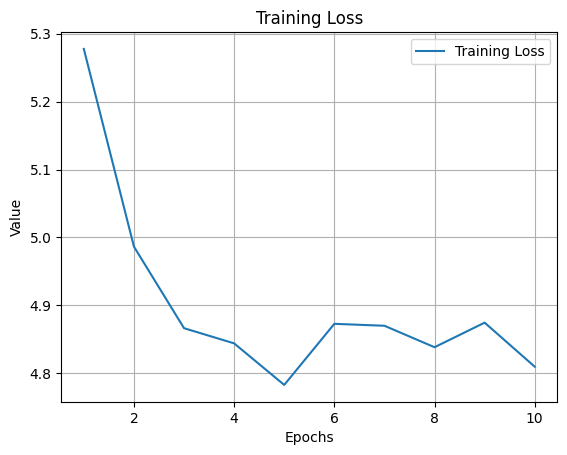

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, num_epochs+1), losses_per_epoch, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

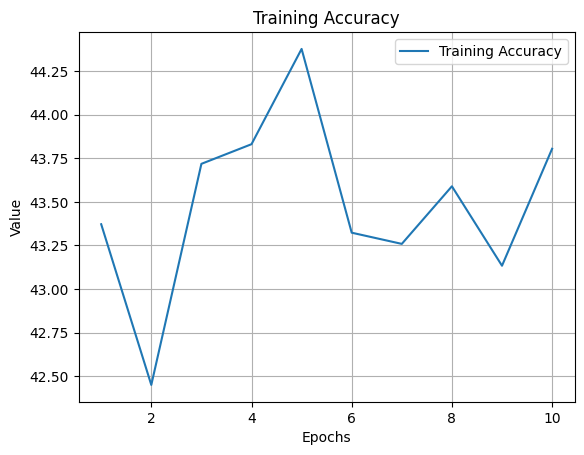

In [ ]:
plt.plot(range(1, num_epochs+1), accuracies_per_epoch, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def test_loop(model,dataloader,loss_fun,device):
    model.eval()
    model.to(device)
    losses = []
    samples,correct = 0,0
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    with torch.no_grad():
        for batch,(x,y) in loop:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x,y)
            loss = loss_fun(y_pred,y.reshape(-1))
            losses.append(loss.item())
            _,predpos=y_pred.max(1)
            samples+=len(y.reshape(-1))
            correct+=(predpos==y.reshape(-1)).sum().item()
            loop.set_postfix(loss=loss.item())

    print("Final Test Accuracy = ",100 * (correct/samples))

In [ ]:
test_loop(model,test_loader,loss_fun,device)

100%|██████████| 56/56 [02:33<00:00,  2.75s/it, loss=5.27]

Final Test Accuracy =  47.160390177082064


In [ ]:
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model.to(device)
def decode_summary(tokenizer, summary_ids):
    summary_tokens = tokenizer.convert_ids_to_tokens(summary_ids)
    summary = tokenizer.convert_tokens_to_string(summary_tokens)
    summary = summary.replace("[CLS]", "").replace("[SEP]", "").strip()
    return summary


In [ ]:
def test_loop(model, dataloader, loss_fun, device, decode_summary):
    model.eval()
    model.to(device)
    losses = []
    samples, correct = 0, 0
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
    predicted_summaries = []
    actual_summaries = []

    with torch.no_grad():
        for batch, (x, y) in loop:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x, y)

            y_tokens = y.tolist()
            y_pred_scores = y_pred.tolist()
            actual_summaries = [bert_tokenizer.decode(tokens, skip_special_tokens=True) for tokens in y_tokens]

            predicted_summaries = []
            for pred_scores in y_pred_scores:
                predicted_tokens = [pred_scores.index(max(pred_scores))]
                predicted_summary = bert_tokenizer.decode(predicted_tokens, skip_special_tokens=True)
                predicted_summaries.append(predicted_summary)
            loss = loss_fun(y_pred, y.reshape(-1))
            losses.append(loss.item())

            _, predpos = y_pred.max(1)
            samples += len(y.reshape(-1))
            correct += (predpos == y.reshape(-1)).sum().item()
            loop.set_postfix(loss=loss.item())

    print("Final Test Accuracy = ", 100 * (correct / samples))

    return actual_summaries, predicted_summaries


In [ ]:
predicted_summaries, actual_summaries=test_loop(model,test_loader,loss_fun,device, decode_summary)

  0%|          | 0/56 [00:00<?, ?it/s]2024-04-11 17:51:09.187430: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 17:51:09.187545: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 17:51:09.320285: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
100%|██████████| 56/56 [06:52<00:00,  7.36s/it, loss=5.28]


Final Test Accuracy =  47.159285485456735


In [ ]:
for i in range(4):
    print("Predicted summary",i+1,":", predicted_summaries[i])
    print("Actual summary",i+1,":",actual_summaries[i])
    print()
    print()

Predicted summary 1 : storage system incorporated application developed security firm ami allows every action computer logged people need recognise using pc representative company employers legal requirement store data added system joint venture security firm ami storage specialists bridgehead software ironically impetus developing system came result freedom information act requires companies store data certain
Actual summary 1 : storage system incorporated application developed security firm ami allows every action computer logged people need recognise using pc representative company employers legal requirement store data added system joint venture security firm ami storage specialists bridgehead software ironically impetus developing system came result freedom information act requires companies store data certain


Predicted summary 2 : mr brown signed debt relief deal tanzania could cost uk billion top relief deal tanzania mr brown said uk would make similar offers poorer nations ar

## model-2 (Transformer)

In [ ]:

nlp = spacy.load("en_core_web_sm")
tokenizer = Tokenizer(nlp.vocab)

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using",device)

Using cuda


In [ ]:
df = data

In [ ]:

df = df.rename(columns = {"articles":"source_text","summaries":"summary_text"})
X,Y = df["source_text"],df["summary_text"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
train_df = pd.DataFrame({'source_text': X_train, 'summary_text': Y_train})
test_df = pd.DataFrame({'source_text': X_test, 'summary_text': Y_test})

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}


stop_words = set(stopwords.words('english'))

In [ ]:
def text_cleaner(text):
    newString = text.lower()
    newString = newString.replace('"', "'")
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    tokens = [w for w in newString.split() if not w in stop_words]
    return " ".join(tokens)

In [ ]:

train_df['source_text'] = train_df['source_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])
train_df['summary_text'] = train_df['summary_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])

test_df['source_text'] = test_df['source_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])
test_df['summary_text'] = test_df['summary_text'].apply(lambda x: [token.text.lower() for token in tokenizer(text_cleaner(x))])

In [ ]:
train_df.head()

,source_text,summary_text
1490,"[blair, buys, copies, new, band, aidprime, min...","[predicted, band, aid, song, sell, copies, uk,..."
2001,"[bbc, poll, indicates, economic, gloomcitizens...","[percentage, terms, average, respondents, coun..."
1572,"[smith, loses, us, box, office, crownnew, come...","[topping, chart, two, consecutive, weeks, smit..."
1840,"[ask, jeeves, tips, online, ad, revivalask, je...","[ask, jeeves, become, third, leading, online, ..."
610,"[evertons, weir, cools, euro, hopeseverton, de...","[everton, defender, david, weir, played, talk,..."


In [ ]:

all_tokens = train_df['source_text'].tolist() + train_df['summary_text'].tolist() + test_df['source_text'].tolist() + test_df['summary_text'].tolist()
source_vocab = {actual_word: idx for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in all_tokens for token in tokens)), key=lambda x: x[1]))}
target_vocab = {actual_word: idx for idx, (word_num, actual_word) in enumerate(sorted(enumerate(set(token for tokens in all_tokens for token in tokens)), key=lambda x: x[1]))}

In [ ]:
temp = list(sorted(source_vocab.items()))
for word, idx in temp[-5:]:
    print(word,idx)

zurich 39662
zurichs 39663
zutons 39664
zvonareva 39665
zvyagintsev 39666


In [ ]:

class CustomDataset(Dataset):
    def __init__(self, source_texts, target_summaries, source_vocab, target_vocab):
        self.source_texts = source_texts
        self.target_summaries = target_summaries
        self.source_vocab = source_vocab
        self.target_vocab = target_vocab

    def __len__(self):
        return len(self.source_texts)

    def __getitem__(self, idx):
        source_text = [self.source_vocab[word] for word in self.source_texts[idx]]
        target_summary = [self.target_vocab[word] for word in self.target_summaries[idx]]
        return torch.tensor(source_text), torch.tensor(target_summary)

In [ ]:
train_dataset = CustomDataset(train_df['source_text'].tolist(), train_df['summary_text'].tolist(),source_vocab, target_vocab)
test_dataset = CustomDataset(test_df['source_text'].tolist(), test_df['summary_text'].tolist(),source_vocab, target_vocab)

In [ ]:
def get_max_seqlen():
    max_length = 0
    for index, row in train_df.iterrows():
        row_length = len(row['source_text'])
        max_length = max(max_length, row_length)
    for index, row in test_df.iterrows():
        row_length = len(row['source_text'])
        max_length = max(max_length, row_length)
    print("Max length in dataset ",max_length)
    return max_length

In [ ]:
def collate_fn(batch):
    sources, targets = zip(*batch)
    padded_sources = pad_sequence(sources, batch_first=True)
    padded_targets = pad_sequence(targets, batch_first=True)
    return padded_sources, padded_targets

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super(MultiHeadAttention,self).__init__()
        assert embedding_dim % num_heads == 0, "embedding_dim must be divisible by num_heads"

        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.dim_perhead = embedding_dim // num_heads

        self.W_q = nn.Linear(embedding_dim, embedding_dim)
        self.W_k = nn.Linear(embedding_dim, embedding_dim)
        self.W_v = nn.Linear(embedding_dim, embedding_dim)
        self.W_o = nn.Linear(embedding_dim, embedding_dim)

    def scaled_dot_product_attention(self,Q,K,V,mask=None):

        K = K.transpose(-2,-1)
        attn_scores = torch.matmul(Q,K) / math.sqrt(self.dim_perhead)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        x = x.view(batch_size, seq_length,self.num_heads,self.dim_perhead)
        x = x.transpose(1,2)
        return x

    def combine_heads(self, x):
        batch_size, _, seq_length, dim_perhead = x.size()
        x = x.transpose(1,2).contiguous()
        x = x.view(batch_size, seq_length,self.embedding_dim)
        return x

    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [ ]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length,dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model,2).float() * -(math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe',pe.unsqueeze(0))

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x,mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x


class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x,tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x,enc_output,enc_output,src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length,device=device), diagonal=1)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [ ]:
src_vocab_size = len(source_vocab)
tgt_vocab_size = len(target_vocab)
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = get_max_seqlen()
dropout = 0.1
num_workers = 2
num_epochs = 10

model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
print(model)

Max length in dataset  2211
Transformer(
  (encoder_embedding): Embedding(39667, 512)
  (decoder_embedding): Embedding(39667, 512)
  (positional_encoding): PositionalEncoding()
  (encoder_layers): ModuleList(
    (0-5): 6 x EncoderLayer(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=512, out_features=512, bias=True)
        (W_k): Linear(in_features=512, out_features=512, bias=True)
        (W_v): Linear(in_features=512, out_features=512, bias=True)
        (W_o): Linear(in_features=512, out_features=512, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bias=True)
      )
      (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (decoder_layers): ModuleList(
    (0-5): 6 x DecoderL

In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(trainable_params)

105106675


In [ ]:

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

In [ ]:
source_dummy,target_dummy = next(iter(train_loader))

In [ ]:
print(source_dummy.shape,target_dummy.shape)

torch.Size([4, 285]) torch.Size([4, 146])


In [ ]:
print(source_dummy[1])

tensor([25570, 26003, 27129,  5675, 27488, 27127, 26060,  5892, 16044, 27805,
        16027, 33776,  9379, 35133, 31941, 34341,  5300, 25570, 27188, 20812,
        20437, 16342, 26003, 27129, 24190,  3394,  8677, 15437, 32562, 26003,
        19306, 35133, 13537, 16959, 35837, 25570, 27129, 18936,  6728, 20408,
        27296, 27262, 26008, 37375, 39209, 27128,  5340,  7795, 21614, 32562,
        12278, 22558, 38158, 20817, 15087, 35113, 16342, 26003, 27129, 25579,
         9723, 22864,  7773,  8010, 16959, 37375,  9391,  6913, 24447,  9379,
        38477, 16027, 33776, 23126, 18454,  4052, 32561, 32562,  7010, 35113,
         1082, 29458, 27884,  9517, 27129, 27262, 16959, 27805, 12952, 16957,
        29237, 12952, 26060, 32542, 38245,  8481, 13537,  1097, 17508, 27129,
         7773, 25736, 22075, 33612,  5892, 27261, 27132, 26008, 16342, 31333,
        16027, 33776, 33689, 28283, 20069, 26015,  8959, 39147, 27130, 16342,
        17631, 14730, 16027, 33776,  6072, 29649, 27128, 30323, 

In [ ]:
print(torch.min(target_dummy),torch.max(target_dummy))

tensor(0) tensor(39344)


In [ ]:
model.to(device)
source_dummy = source_dummy.to(device)
target_dummy = target_dummy.to(device)
print()

In [ ]:
y_pred = model(source_dummy,target_dummy)
print(y_pred.shape,target_dummy.shape)

torch.Size([4, 146, 39667]) torch.Size([4, 146])


In [ ]:
y_pred = y_pred.reshape(-1,len(target_vocab))
target_dummy = target_dummy.reshape(-1)
print(y_pred.shape,target_dummy.shape)

torch.Size([584, 39667]) torch.Size([584])


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)

In [ ]:
def train_loop(model,dataloader,loss_fun,optimizer,device):
    model.train()
    model.to(device)
    min_loss = None
    losses_per_epoch=[]
    accuracies_per_epoch=[]
    for epoch in range(10):
        losses = []
        accuracies = []
        loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)
        for batch,(x,y) in loop:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x,y)
            loss = loss_fun(y_pred.reshape(-1,len(target_vocab)),y.reshape(-1))
            losses.append(loss.detach().item())

            accuracy = check_accuracy(y_pred.reshape(-1,len(target_vocab)),y.reshape(-1))
            accuracies.append(accuracy.detach().item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            loop.set_description(f"Epoch [{epoch}/{num_epochs}] ")
            loop.set_postfix(loss=loss.detach().item(), accuracy=accuracy.detach().item())

        moving_loss = sum(losses) / len(losses)
        moving_accuracy = sum(accuracies) / len(accuracies)
        losses_per_epoch.append(moving_loss)
        accuracies_per_epoch.append(moving_accuracy)
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        if min_loss == None:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        elif moving_loss < min_loss:
            min_loss = moving_loss
            save_checkpoint(checkpoint)
        print('Epoch {0} : Loss = {1} , Training Accuracy={2}'.format(epoch, moving_loss, moving_accuracy))
    return losses_per_epoch, accuracies_per_epoch

In [ ]:
losses_per_epoch, accuracies_per_epoch=train_loop(model,train_loader,criterion,optimizer,device)

Epoch [0/10] : 100%|██████████| 445/445 [01:10<00:00,  6.28it/s, accuracy=34.3, loss=4.82]


Saving weights-->
Epoch 0 : Loss = 7.127807940793841 , Training Accuracy=21.32000924137871


Epoch [1/10] : 100%|██████████| 445/445 [01:14<00:00,  5.97it/s, accuracy=54.5, loss=3.02]


Saving weights-->
Epoch 1 : Loss = 3.8720847424496427 , Training Accuracy=45.29599462359139


Epoch [2/10] : 100%|██████████| 445/445 [01:14<00:00,  5.99it/s, accuracy=63.7, loss=1.68]


Saving weights-->
Epoch 2 : Loss = 2.6874132191197257 , Training Accuracy=53.02130525138941


Epoch [3/10] : 100%|██████████| 445/445 [01:14<00:00,  5.96it/s, accuracy=60.3, loss=1.23] 


Saving weights-->
Epoch 3 : Loss = 2.02372146938624 , Training Accuracy=56.460329797294705


Epoch [4/10] : 100%|██████████| 445/445 [01:14<00:00,  5.98it/s, accuracy=68.1, loss=0.922]


Saving weights-->
Epoch 4 : Loss = 1.5985847858900435 , Training Accuracy=59.602192070778834


Epoch [5/10] : 100%|██████████| 445/445 [01:14<00:00,  5.95it/s, accuracy=45.9, loss=1.09] 


Saving weights-->
Epoch 5 : Loss = 1.3050461248065648 , Training Accuracy=60.658801029505355


Epoch [6/10] : 100%|██████████| 445/445 [01:14<00:00,  5.99it/s, accuracy=62.1, loss=1.1]  


Saving weights-->
Epoch 6 : Loss = 1.0752889677379909 , Training Accuracy=62.425270209151705


Epoch [7/10] : 100%|██████████| 445/445 [01:14<00:00,  5.99it/s, accuracy=59.8, loss=0.779]


Saving weights-->
Epoch 7 : Loss = 0.9041820073395632 , Training Accuracy=63.82288786641667


Epoch [8/10] : 100%|██████████| 445/445 [01:14<00:00,  6.01it/s, accuracy=70.7, loss=0.698]


Saving weights-->
Epoch 8 : Loss = 0.7607054908623856 , Training Accuracy=64.69046794591326


Epoch [9/10] : 100%|██████████| 445/445 [01:14<00:00,  5.99it/s, accuracy=73.7, loss=0.83] 


Saving weights-->
Epoch 9 : Loss = 0.6428818540626697 , Training Accuracy=65.4277764138211


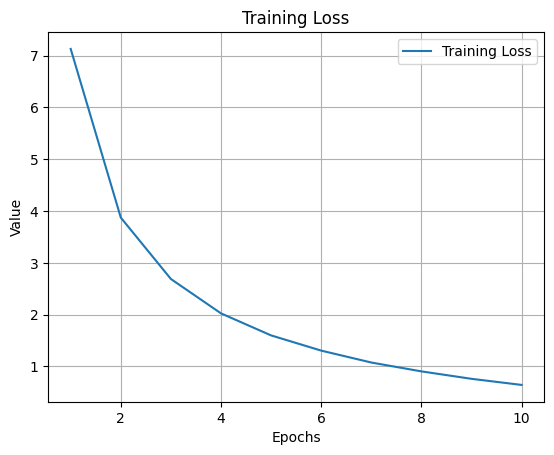

In [ ]:
plt.plot(range(1, num_epochs+1), losses_per_epoch, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


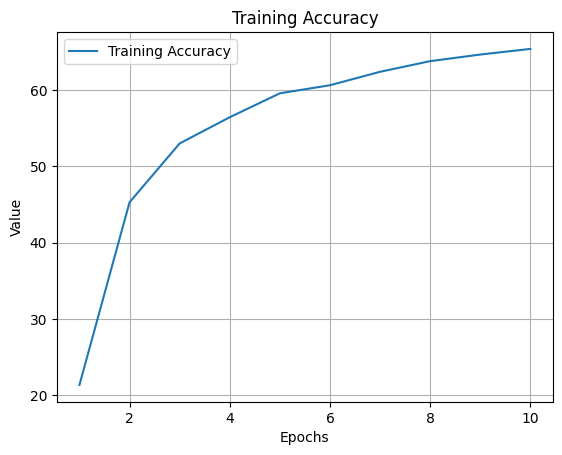

In [ ]:
plt.plot(range(1, num_epochs+1), accuracies_per_epoch, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def tokens_to_words(indices, vocab):
    words = [list(vocab.keys())[list(vocab.values()).index(idx)] for idx in indices]
    return words

In [ ]:

from tabulate import tabulate

def test_loop(model, dataloader, loss_fun, device, target_vocab, excel_filename):
    model.eval()
    model.to(device)
    losses = []
    samples, correct = 0, 0
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)

    data = []

    with torch.no_grad():
        for batch, (x, y) in loop:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x, y)
            loss = loss_fun(y_pred.reshape(-1, len(target_vocab)), y.reshape(-1))
            losses.append(loss.detach().item())
            _, predpos = y_pred.reshape(-1, len(target_vocab)).max(1)
            samples += len(y.reshape(-1))
            correct += (predpos == y.reshape(-1)).sum().item()
            loop.set_postfix(loss=loss.item())
            if batch < 5:
                for i in range(len(y_pred)):
                    summary_words_pred = tokens_to_words(y_pred[i].argmax(dim=1).tolist(), target_vocab)
                    summary_words_actual = tokens_to_words(y[i].tolist(), target_vocab)

                    original_input = " ".join(summary_words_actual[:50])
                    predicted_summary = " ".join(summary_words_pred[:50])
                    data.append((original_input, predicted_summary))

    df = pd.DataFrame(data, columns=['Original Input', 'Predicted Summary'])
    df.to_excel(excel_filename, index=False, engine='openpyxl')

    print("DataFrame saved to", excel_filename)
    print("Final Test Accuracy = ", 100 * (correct / samples))


In [ ]:
test_loop(model,test_loader,criterion,device,target_vocab,'test_data1.xlsx')

100%|██████████| 112/112 [00:15<00:00,  7.28it/s, loss=2.49] 


DataFrame saved to test_data1.xlsx
Final Test Accuracy =  58.35952370412997


In [ ]:

df = pd.read_excel("/kaggle/working/test_data1.xlsx")


In [ ]:
df

,Original Input,Predicted Summary
0,think anyone say said one thing public done an...,think anyone say said one thing public done an...
1,benitez responded spoke steven said future bet...,benitez responded spoke steven said future bet...
2,redmond also brought teen soap hollyoaks chann...,argument also brought threat soap collapse cha...
3,speaking outside olympic primary school mr bro...,speaking outside olympic primary school mr bro...
4,still basking relatively recent glory last yea...,still ford relatively recent glory last year s...
5,viotti director la fenice since conducted reno...,hip director la yen since conducted budgets op...
6,crude oil prices surged back barrel mark thurs...,crude oil prices surged back barrel mark thurs...
7,security firm network box said stopped copies ...,security firm network box said stopped copies ...
8,hassel says juninho bought new home would desp...,turning says juninho bought new home would des...
9,storage system incorporated application develo...,storage system incorporated application develo...


In [ ]:
!pip install rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=70d359a1f70b94064b2201a27d317e15e2ba678969b6c959151a64a0dfc74691
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score
Note: you may need to restart the kernel to use updated packages.


In [ ]:

class CustomLoss(nn.Module):
    def __init__(self, ignore_index=0, content_lambda=1.0, fluency_lambda=0.5):
        super(CustomLoss, self).__init__()
        self.ignore_index = ignore_index
        self.content_lambda = content_lambda
        self.fluency_lambda = fluency_lambda
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=ignore_index)

    def forward(self, y_pred, y_true):
        ce_loss = self.ce_loss(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1))
        fluency_loss = self.compute_fluency_loss(y_pred)
        loss = self.content_lambda * ce_loss + self.fluency_lambda * fluency_loss
        return loss

    def compute_fluency_loss(self, y_pred):
        smoothness_penalty = torch.mean(torch.abs(y_pred[:, 1:] - y_pred[:, :-1]))
        return smoothness_penalty


In [ ]:
import torch
import torch.nn as nn
from rouge_score import rouge_scorer
from datasets import load_metric
class CustomLoss(nn.Module):
    def _init_(self, ignore_index=0, content_lambda=1.0, fluency_lambda=0.5, rouge_lambda=0.1):
        super(CustomLoss, self)._init_()
        self.ignore_index = ignore_index
        self.content_lambda = content_lambda
        self.fluency_lambda = fluency_lambda
        self.rouge_lambda = rouge_lambda
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=ignore_index)
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def forward(self, y_pred, y_true):
        ce_loss = self.ce_loss(y_pred.view(-1, y_pred.size(-1)), y_true.view(-1))
        fluency_loss = self.compute_fluency_loss(y_pred)
        rouge_loss = self.compute_rouge_loss(y_pred, y_true)
        loss = self.content_lambda * ce_loss + self.fluency_lambda * fluency_loss + self.rouge_lambda * rouge_loss
        return loss

    def compute_fluency_loss(self, y_pred):
        smoothness_penalty = torch.mean(torch.abs(y_pred[:, 1:] - y_pred[:, :-1]))
        return smoothness_penalty

    def compute_rouge_loss(self, y_pred, y_true):
        rouge_loss = 0.0
        rouge_scores = self.compute_rouge_scores()
        rouge_loss += 1 - sum(rouge_scores.values()) / len(rouge_scores)
        return rouge_loss / len(y_pred)

    def indices_to_text(self, y_pred, y_true):
        for i in range(len(y_pred)):
                    summary_words_pred = tokens_to_words(y_pred[i], target_vocab)
                    summary_words_actual = tokens_to_words(y[i], target_vocab)
                    original_input = " ".join(summary_words_actual[:50])
                    predicted_summary = " ".join(summary_words_pred[:50])
        return original_input, predicted_summary

    def compute_rouge_scores(self, y_pred_text='', y_true_text=''):
        rouge_metric = load_metric('rouge', trust_remote_code=True)
        rouge_metric.add(prediction=y_pred_text, reference=y_true_text)
        score = rouge_metric.compute()
        rouge_names= ["rouge1","rouge2","rougeL","rougeLsum"]
        rouge_scores = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
        return rouge_scores

In [ ]:
custom_criterion = CustomLoss(ignore_index=0, content_lambda=1.0, fluency_lambda=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
losses_per_epoch, accuracies_per_epoch=train_loop(model, train_loader, custom_criterion, optimizer, device)


Epoch [0/10] : 100%|██████████| 445/445 [01:14<00:00,  5.96it/s, accuracy=61.6, loss=0.506]


Saving weights-->
Epoch 0 : Loss = 0.6172519584050339 , Training Accuracy=65.20786796312653


Epoch [1/10] : 100%|██████████| 445/445 [01:14<00:00,  5.97it/s, accuracy=57.8, loss=0.767]


Saving weights-->
Epoch 1 : Loss = 0.4639152984605746 , Training Accuracy=65.86746491850093


Epoch [2/10] : 100%|██████████| 445/445 [01:14<00:00,  6.01it/s, accuracy=68.7, loss=0.0401]


Saving weights-->
Epoch 2 : Loss = 0.3449991826344742 , Training Accuracy=67.83659258638875


Epoch [3/10] : 100%|██████████| 445/445 [01:15<00:00,  5.93it/s, accuracy=83.9, loss=0.426] 


Saving weights-->
Epoch 3 : Loss = 0.25182795815086095 , Training Accuracy=67.10477708966545


Epoch [4/10] : 100%|██████████| 445/445 [01:14<00:00,  5.98it/s, accuracy=53, loss=0.228]   


Saving weights-->
Epoch 4 : Loss = 0.1799734270053633 , Training Accuracy=67.98201499253176


Epoch [5/10] : 100%|██████████| 445/445 [01:14<00:00,  6.00it/s, accuracy=52.1, loss=0.155] 


Saving weights-->
Epoch 5 : Loss = 0.12421290450467823 , Training Accuracy=68.09080351925968


Epoch [6/10] : 100%|██████████| 445/445 [01:13<00:00,  6.02it/s, accuracy=81.7, loss=0.144] 


Saving weights-->
Epoch 6 : Loss = 0.08112323831850558 , Training Accuracy=67.983158711637


Epoch [7/10] : 100%|██████████| 445/445 [01:14<00:00,  5.99it/s, accuracy=51.3, loss=0.07]   


Saving weights-->
Epoch 7 : Loss = 0.04770048377156425 , Training Accuracy=67.87280205715908


Epoch [8/10] : 100%|██████████| 445/445 [01:14<00:00,  5.99it/s, accuracy=78.2, loss=0.0235] 


Saving weights-->
Epoch 8 : Loss = 0.026424377236326926 , Training Accuracy=67.48659910566352


Epoch [9/10] : 100%|██████████| 445/445 [01:14<00:00,  6.01it/s, accuracy=58.3, loss=0.0161]  


Saving weights-->
Epoch 9 : Loss = 0.01378019278453077 , Training Accuracy=68.1035713324386


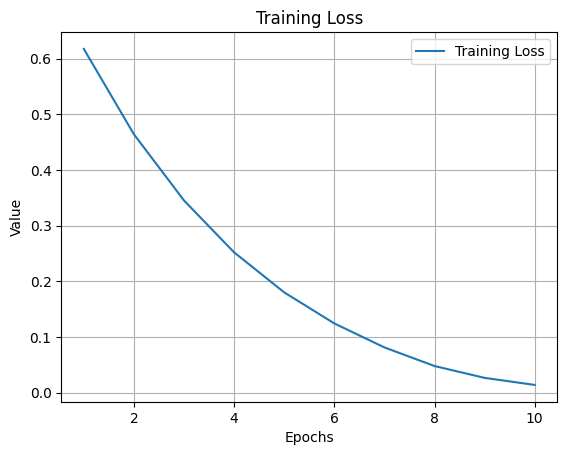

In [ ]:
plt.plot(range(1, num_epochs+1), losses_per_epoch, label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

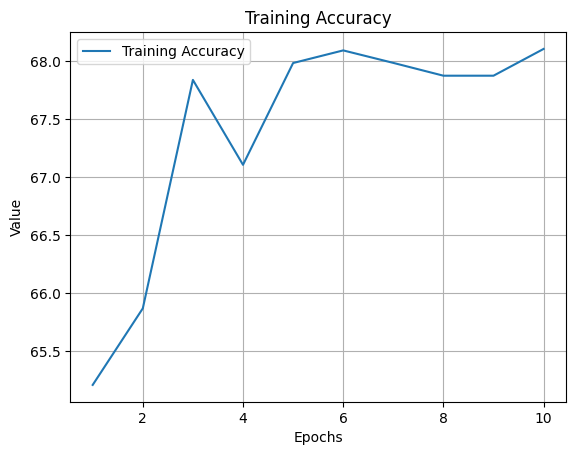

In [ ]:
plt.plot(range(1, num_epochs+1), accuracies_per_epoch, label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:


def test_loop(model, dataloader, loss_fun, device, target_vocab, excel_filename):
    model.eval()
    model.to(device)
    losses = []
    samples, correct = 0, 0
    loop = tqdm(enumerate(dataloader), total=len(dataloader), leave=True)

    data = []

    with torch.no_grad():
        for batch, (x, y) in loop:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x, y)
            loss = loss_fun(y_pred.reshape(-1, len(target_vocab)), y.reshape(-1))
            losses.append(loss.detach().item())
            _, predpos = y_pred.reshape(-1, len(target_vocab)).max(1)
            samples += len(y.reshape(-1))
            correct += (predpos == y.reshape(-1)).sum().item()

            loop.set_postfix(loss=loss.item())

            if batch < 5:
                for i in range(len(y_pred)):
                    summary_words_pred = tokens_to_words(y_pred[i].argmax(dim=1).tolist(), target_vocab)
                    summary_words_actual = tokens_to_words(y[i].tolist(), target_vocab)

                    original_input = " ".join(summary_words_actual[:50])
                    predicted_summary = " ".join(summary_words_pred[:50])
                    data.append((original_input, predicted_summary))

    df = pd.DataFrame(data, columns=['Original Input', 'Predicted Summary'])
    df.to_excel(excel_filename, index=False, engine='openpyxl')

    print("DataFrame saved to", excel_filename)
    print("Final Test Accuracy = ", 100 * (correct / samples))


In [ ]:
test_loop(model, test_loader, custom_criterion, device, target_vocab, 'test_data.xlsx')


100%|██████████| 112/112 [00:15<00:00,  7.08it/s, loss=2.3]  

DataFrame saved to test_data.xlsx
Final Test Accuracy =  59.67863308397149


In [ ]:

df = pd.read_excel("/kaggle/working/test_data.xlsx")


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Original Input     20 non-null     object
 1   Predicted Summary  20 non-null     object
dtypes: object(2)
memory usage: 448.0+ bytes


In [ ]:
df

,Original Input,Predicted Summary
0,think anyone say said one thing public done an...,think anyone say said one thing public done an...
1,benitez responded spoke steven said future bet...,benitez responded spoke steven said future bet...
2,redmond also brought teen soap hollyoaks chann...,paula also brought teen soap complex channel c...
3,speaking outside olympic primary school mr bro...,speaking outside olympic primary school mr bro...
4,still basking relatively recent glory last yea...,still assume relatively recent glory last year...
5,viotti director la fenice since conducted reno...,wake director la topping since conducted budge...
6,crude oil prices surged back barrel mark thurs...,crude oil prices surged back barrel mark thurs...
7,security firm network box said stopped copies ...,security firm network box said stopped copies ...
8,hassel says juninho bought new home would desp...,hantuchova says juninho bought new home would ...
9,storage system incorporated application develo...,storage system incorporated application develo...


## model-3 (Bart, Peagus and T5)

In [ ]:
dataframe = data3
dataframe

,articles,summaries,categories,articles_length,summaries_length
0,Tory leader 'cleared' over work\n\nScottish Co...,"Mr McLetchie said: ""I'm quite clear that no co...",politics,284,148
1,"Nat Insurance to rise, say Tories\n\nNational ...",Tony Blair has said he does not want higher ta...,politics,431,187
2,'No more concessions' on terror\n\nCharles Cla...,"On Monday, MPs voted 272-219 in favour of the ...",politics,531,223
3,Howard pitches for UK ethnic vote\n\nMichael H...,"""So I say to all those people from ethnic mino...",politics,377,158
4,Labour faces 'cold calls' inquiry\n\nLabour is...,The information commissioner is to look into a...,politics,695,313
...,...,...,...,...,...
2220,Germany nears 1990 jobless level\n\nGerman une...,"""The three years of stagnation in the German e...",business,345,128
2221,Yukos drops banks from court bid\n\nRussian oi...,Russian oil company Yukos has dropped the thre...,business,246,103
2222,Fannie Mae 'should restate books'\n\nUS mortga...,US mortgage company Fannie Mae should restate ...,business,249,72
2223,Israel looks to US for bank chief\n\nIsrael ha...,Mr Fischer will face a delicate balancing act ...,business,255,131


In [ ]:
!pip install transformers[sentencepiece] datasets rouge_score py7zr -q

In [ ]:
import time
from transformers import pipeline,set_seed
from transformers import AutoModelForSeq2SeqLM,AutoTokenizer
from datasets import load_metric


In [ ]:

total_length = len(dataframe)
train_length = int(0.7 * total_length)
val_length = test_length = int(0.15 * total_length)

train = dataframe[:train_length]
X_train = dataframe['articles'][:train_length]
Y_train = dataframe['summaries'][:train_length]

val = dataframe[train_length:train_length+val_length]
X_val = dataframe['articles'][train_length:train_length+val_length]
Y_val = dataframe['summaries'][train_length:train_length+val_length]

test = dataframe[train_length+val_length:]
X_test = dataframe['articles'][train_length+val_length:]
Y_test = dataframe['summaries'][train_length+val_length:]

print("Train set size:", len(X_train), len(Y_train))
print("Validation set size:", len(X_val), len(Y_val))
print("Test set size:", len(X_test), len(Y_test))


Train set size: 1557 1557
Validation set size: 333 333
Test set size: 335 335


In [ ]:
sample_text = train["articles"][1]
print(sample_text)

summaries = {}

nat insurance rise say toriesnational insurance raised labour wins next election tory leader michael howard claimedtony blair said want higher tax rates top earners wednesday said tax promises would left labours manifesto prime ministers questions also saw mr blair predict new plans would probably cut net immigration attacked tory plans process asylum claims abroad mr howard said labour proposed idea toothe commons questions session saw leaders two biggest parties shape forthcoming election campaign tories promised â£4bn tax cuts yet say fall mr howard pointed institute fiscal studies predictions labour need increase taxes cover â£11bn gap spending plans accused ministers wasting money unsuccessful attempts curb bad behaviour truancy schools slow asylum processing good mr blair claiming tax pledges left manifesto given one mps tuesday top rate income tax argued mr howard pointing national insurance added everyone knows tax go labour isnt clear tax would bemr blair instead hailed labour

In [ ]:

def baseline_summary_three_sent(text):
    return " ".join(sent_tokenize(text)[:3])

summaries['baseline'] = baseline_summary_three_sent(sample_text)
summaries['baseline']


'nat insurance rise say toriesnational insurance raised labour wins next election tory leader michael howard claimedtony blair said want higher tax rates top earners wednesday said tax promises would left labours manifesto prime ministers questions also saw mr blair predict new plans would probably cut net immigration attacked tory plans process asylum claims abroad mr howard said labour proposed idea toothe commons questions session saw leaders two biggest parties shape forthcoming election campaign tories promised â£4bn tax cuts yet say fall mr howard pointed institute fiscal studies predictions labour need increase taxes cover â£11bn gap spending plans accused ministers wasting money unsuccessful attempts curb bad behaviour truancy schools slow asylum processing good mr blair claiming tax pledges left manifesto given one mps tuesday top rate income tax argued mr howard pointing national insurance added everyone knows tax go labour isnt clear tax would bemr blair instead hailed labou

In [ ]:
pipe_t5 = pipeline('summarization', model='t5-small')
pipe_t5_out = pipe_t5(sample_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



In [ ]:
pipe_t5_out

[{'summary_text': 'michael howard claimed tax pledges left manifesto given one mps tuesday top rate income tax argued mr howard pointing national insurance added everyone knows tax go labour isnt clear tax would bemr blair instead hailed labours achievement using strong economy invest public services money going extra teachers nurses equipment schools money wasted said tax questions added make commitments tax time manifesto home secretary charles clarke week published plans new points system economic migrants highskilled workers allowed'}]

In [ ]:
summaries['t5'] = " ".join(sent_tokenize(pipe_t5_out[0]['summary_text']))
summaries['t5']

'michael howard claimed tax pledges left manifesto given one mps tuesday top rate income tax argued mr howard pointing national insurance added everyone knows tax go labour isnt clear tax would bemr blair instead hailed labours achievement using strong economy invest public services money going extra teachers nurses equipment schools money wasted said tax questions added make commitments tax time manifesto home secretary charles clarke week published plans new points system economic migrants highskilled workers allowed'

In [ ]:

pipe_bart = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_bart_out = pipe_bart(sample_text)


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:

print(pipe_bart(sample_text, max_length=130, min_length=30, do_sample=False))

[{'summary_text': 'Tories promised â£4bn tax cuts yet say fall tory leader michael howard claimedtony blair said want higher tax rates top earners wednesday said tax promises would left labours manifesto prime ministers questions also saw mr blair predict new plans would probably cut net immigration attacked tory plans process asylum claims abroad.'}]


In [ ]:

summaries["bart"] = " ".join(sent_tokenize(pipe_bart_out[0]["summary_text"]))
summaries["bart"]

'Tories promised â£4bn tax cuts yet say fall mr howard pointed institute fiscal studies predictions labour need increase taxes. nat insurance rise say toriesnational insurance raised labour wins next election tory leader michael howard claimedtony blair said want higher tax rates top earners wednesday said tax promises would left labours manifesto.'

In [ ]:


print("GROUND TRUTH")

print(train["summaries"][1])

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])

GROUND TRUTH
Tony Blair has said he does not want higher tax rates for top earners but on Wednesday said other tax promises would be left to Labour's manifesto.He attacked Tory plans to process asylum claims abroad - but Mr Howard said Labour had proposed the idea too.It was no good Mr Blair claiming tax pledges were being left to the manifesto as he had given one to MPs on Tuesday about the top rate of income tax, argued Mr Howard.Prime minister's questions also saw Mr Blair predict that new plans would probably cut net immigration.Mr Howard read from a letter about the government's own plans at the European Council of Ministers for processing asylum seekers outside the EU.Pointing to national insurance, he added: "Everyone knows tax will go up under Labour: isn't it now clear which tax it would be?"Mr Blair said abuses would be weeded out and chain migration, where families automatically get the right to settle with immigrant workers, would end.Mr Howard pointed to the Institute for 

In [ ]:


rouge_metric = load_metric('rouge')

<ipython-input-49-90542a62301a>:1: FutureWarning:

load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate

/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning:

The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.



In [ ]:


import timeit
start = timeit.timeit()

rouge_names= ["rouge1","rouge2","rougeL","rougeLsum"]
reference = train["summaries"][1]
records = []

for model_name in summaries:
    print(model_name)
    rouge_metric.add(prediction=summaries[model_name], reference=reference)
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
    print('rouge_dict ', rouge_dict)
    records.append(rouge_dict)

pd.DataFrame.from_records(records, index=summaries.keys())

end = timeit.timeit()
print(end - start)

baseline
rouge_dict  {'rouge1': 0.5283842794759824, 'rouge2': 0.2850877192982456, 'rougeL': 0.3406113537117904, 'rougeLsum': 0.3406113537117904}
t5
rouge_dict  {'rouge1': 0.27106227106227104, 'rouge2': 0.08118081180811808, 'rougeL': 0.2271062271062271, 'rougeLsum': 0.2271062271062271}
bart
rouge_dict  {'rouge1': 0.25, 'rouge2': 0.10569105691056911, 'rougeL': 0.12096774193548387, 'rougeLsum': 0.12096774193548387}
0.020433981999303796


In [ ]:

def calculate_metric_on_baseline_test_ds(dataset, metric, column_text='articles', column_summary='summaries'):

    summaries = [baseline_summary_three_sent(text) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    return metric.compute()

In [ ]:

score = calculate_metric_on_baseline_test_ds(test, rouge_metric)
rouge_dict_baseline = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict_baseline, orient='index', columns=['baseline']).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.476834,0.219436,0.291806,0.291662


In [ ]:

def calculate_metric_on_t5_test_ds(dataset, metric, column_text='articles', column_summary='summaries'):

    summaries = [" ".join(sent_tokenize(pipe_t5(text)[0]["summary_text"])) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    return metric.compute()

In [ ]:

start = time.time()

score = calculate_metric_on_t5_test_ds(test, rouge_metric)
rouge_dict_t5 = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict_t5, orient='index', columns=['t5']).T

end = time.time()
print(end - start)

Your max_length is set to 200, but your input_length is only 181. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=90)
Your max_length is set to 200, but your input_length is only 153. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=76)
Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Your max_length is set to 200, but your input_length is only 170. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=85)
Your max_length is set to 200, but your input_length is only 170. Si

1669.2487938404083


In [ ]:
pd.DataFrame.from_dict(rouge_dict_t5, orient='index', columns=['t5']).T

,rouge1,rouge2,rougeL,rougeLsum
t5,0.293182,0.101298,0.210582,0.210648


In [ ]:
def calculate_metric_on_bart_test_ds(dataset, metric, column_text='articles', column_summary='summaries'):

    summaries = ["\n".join(sent_tokenize(pipe_bart(text[:1000])[0]["summary_text"])) for text in dataset[column_text]]
    metric.add_batch(predictions=summaries, references=dataset[column_summary])
    return metric.compute()

In [ ]:

start = time.time()

score = calculate_metric_on_bart_test_ds(test, rouge_metric)
rouge_dict_bart = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)
pd.DataFrame.from_dict(rouge_dict_bart, orient='index', columns=['Bart']).T

end = time.time()
print(end - start)

Your max_length is set to 142, but your input_length is only 126. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)
Your max_length is set to 142, but your input_length is only 131. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)
Your max_length is set to 142, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
Your max_length is set to 142, but your input_length is only 132. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


5558.4552574157715


In [ ]:
pd.DataFrame.from_dict(rouge_dict_bart, orient='index', columns=['Bart']).T

,rouge1,rouge2,rougeL,rougeLsum
Bart,0.279888,0.099405,0.207836,0.226845


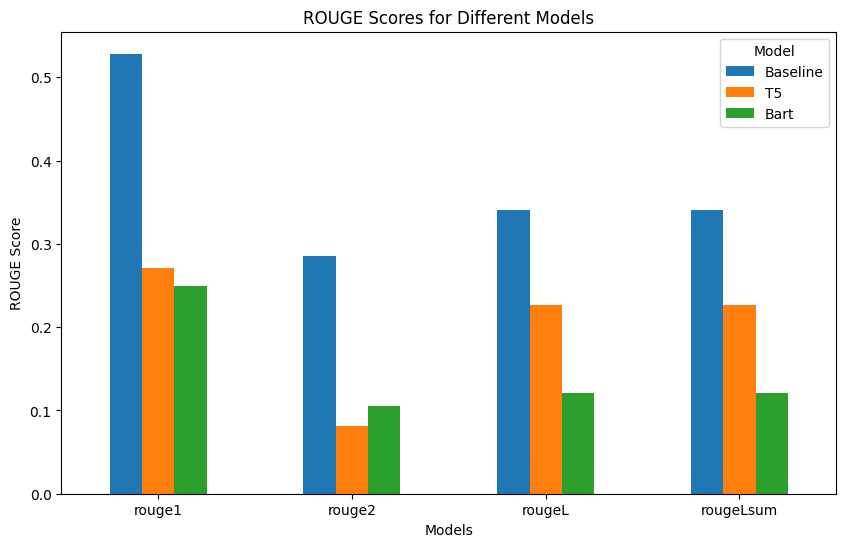

In [ ]:
df = pd.DataFrame.from_records(records)
df = df.transpose()
df.plot(kind='bar',figsize=(10, 6))
plt.title('ROUGE Scores for Different Models')
plt.xlabel('Models')
plt.ylabel('ROUGE Score')
plt.xticks(rotation=0)
plt.legend(labels=['Baseline', 'T5', 'Bart'],
           title='Model')
plt.show()
